# Introduction

Imagine one day, your breathing became consistently labored and shallow. Months later you were finally diagnosed with pulmonary fibrosis, a disorder with no known cause and no known cure, created by scarring of the lungs. If that happened to you, you would want to know your prognosis. That’s where a troubling disease becomes frightening for the patient: outcomes can range from long-term stability to rapid deterioration, but doctors aren’t easily able to tell where an individual may fall on that spectrum. Your help, and data science, may be able to aid in this prediction, which would dramatically help both patients and clinicians.

Current methods make fibrotic lung diseases difficult to treat, even with access to a chest CT scan. In addition, the wide range of varied prognoses create issues organizing clinical trials. Finally, patients suffer extreme anxiety—in addition to fibrosis-related symptoms—from the disease’s opaque path of progression.

Open Source Imaging Consortium (OSIC) is a not-for-profit, co-operative effort between academia, industry and philanthropy. The group enables rapid advances in the fight against Idiopathic Pulmonary Fibrosis (IPF), fibrosing interstitial lung diseases (ILDs), and other respiratory diseases, including emphysematous conditions. Its mission is to bring together radiologists, clinicians and computational scientists from around the world to improve imaging-based treatments.

In this competition, you’ll predict a patient’s severity of decline in lung function based on a CT scan of their lungs. You’ll determine lung function based on output from a spirometer, which measures the volume of air inhaled and exhaled. The challenge is to use machine learning techniques to make a prediction with the image, metadata, and baseline FVC as input.

If successful, patients and their families would better understand their prognosis when they are first diagnosed with this incurable lung disease. Improved severity detection would also positively impact treatment trial design and accelerate the clinical development of novel treatments.
Link: https://www.kaggle.com/c/osic-pulmonary-fibrosis-progression

# Part 1 - Data Exploration and Analysis

On this, part we are going to explore our dataset, such as:
- Check columns types
- Check for NAs
- Convert categories col from object into numeric
- Normalize FVC
- Remove negtaive weeks
- Convert columns flot/int type to 32 & object to int32


In [28]:
#Step:1 - Load dataset
import pandas as pd

trainDF  = pd.read_csv("G:/DataScienceProject/osic-pulmonary-fibrosis-progression/train.csv")
testDF  = pd.read_csv("G:/DataScienceProject/osic-pulmonary-fibrosis-progression/test.csv")
trainDF.head()

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
0,ID00007637202177411956430,-4,2315,58.253649,79,Male,Ex-smoker
1,ID00007637202177411956430,5,2214,55.712129,79,Male,Ex-smoker
2,ID00007637202177411956430,7,2061,51.862104,79,Male,Ex-smoker
3,ID00007637202177411956430,9,2144,53.950679,79,Male,Ex-smoker
4,ID00007637202177411956430,11,2069,52.063412,79,Male,Ex-smoker


In [29]:
#Step:2 - Columns types
trainDF.dtypes

Patient           object
Weeks              int64
FVC                int64
Percent          float64
Age                int64
Sex               object
SmokingStatus     object
dtype: object

In [30]:
#Step:3 - Check NA
trainDF.isna().sum()

Patient          0
Weeks            0
FVC              0
Percent          0
Age              0
Sex              0
SmokingStatus    0
dtype: int64

In [31]:
#Step:4 - Convert object col into numeric
dic = {}
catList = list(trainDF['Sex'].unique()) + list(trainDF['SmokingStatus'].unique())
for i, value in enumerate(catList):
    dic[value] = (i + 3) * 4 - 1
    trainDF = trainDF.replace(value, dic[value])
    testDF = testDF.replace(value, dic[value])


C:\Program Files\Python38\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


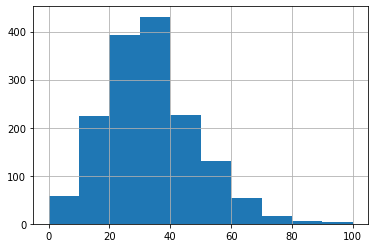

In [32]:
#Step:5 - add normalize FVC
import numpy as np

trainDF['FVCnrm'] = 0
testDF['FVCnrm'] = 0
rangeFVC = trainDF.FVC.max() - trainDF.FVC.min()
for i in range(0, len(trainDF.FVC)):
    trainDF['FVCnrm'].loc[i] = int(((trainDF.FVC[i] - trainDF.FVC.min()) / rangeFVC) * 100)


for i in range(0, len(testDF.FVC)):
    testDF['FVCnrm'].loc[i] = int(((testDF.FVC[i] - trainDF.FVC.min()) / rangeFVC) * 100)

#Limit demimal palce
trainDF['Percent'] = round(trainDF['Percent'], 3)
testDF['Percent'] = round(trainDF['Percent'], 3)

#Remove negtaive weeks
trainDF = trainDF[trainDF.Weeks >= 0]
trainDF.FVCnrm.hist()

In [33]:
#Step:6 - Convert columns flot/int type to 32 & object to int32
colList = list(trainDF)[1:]
for i, value in enumerate(colList):
    if trainDF[value].dtypes == 'int64':
        trainDF[value] = trainDF[value].astype('int32')
        testDF[value] = testDF[value].astype('int32')
    elif trainDF[value].dtypes == 'float64':
        trainDF[value] = trainDF[value].astype('float32')
        testDF[value] = testDF[value].astype('float32')
    elif trainDF[value].dtypes == 'object':
        trainDF[value] = trainDF[value].astype('int32')
        testDF[value] = testDF[value].astype('int32')
        
trainDF.dtypes
trainDF.to_csv("G:/DataScienceProject/osic-pulmonary-fibrosis-progression/trainDF_Phase1.csv", index=False)
testDF.to_csv("G:/DataScienceProject/osic-pulmonary-fibrosis-progression/testDF_Phase1.csv", index=False)

# Part 2 - Image Processing & Classification

On this part, we will do:
- Convert DCM (CT) into JPG format
- Crop images
- Resize images into 224X224
- Split image for image classes (FVC)
- Deep Learning Fastai
- Prediction

In [16]:
#Step:7 - Covert dcm into jpg format
import pydicom as dicom
import os
import cv2

def dcmTOjpeg(path):
    folderList = os.listdir(path)
    for i, valueA in enumerate(folderList):
        subFolderList = os.listdir(path + valueA)
        for j, valueB in enumerate(subFolderList):
            srcImg = path + valueA + '/' + valueB
            # print(srcImg)
            try:
                ds = dicom.dcmread(srcImg)
                pixel_array_numpy = ds.pixel_array
                dstImg = srcImg[:-3] + 'jpg'
                cv2.imwrite(dstImg, pixel_array_numpy)
                os.remove(srcImg)
            except:
                os.remove(srcImg)            

    return

In [18]:
#Step:8
path = 'G:/DataScienceProject/osic-pulmonary-fibrosis-progression/train/'
dcmTOjpeg(path)
path = 'G:/DataScienceProject/osic-pulmonary-fibrosis-progression/test/'
dcmTOjpeg(path)
print("Done")

Done


In [19]:
#Step:9 - Image crop
import os
import cv2
def imgCrop(path):
        folderList = os.listdir(path)
        for i, valueA in enumerate(folderList):
            subFolderList = os.listdir(path + valueA)
            for j, valueB in enumerate(subFolderList):
                srcImg = path + valueA + '/' + valueB
                img = cv2.imread( srcImg)
                width = img.shape[1]
                height = img.shape[0]
                x1 = int(width/4)
                x2 = width - x1
                y1 = int(height/4)
                y2 = height - y1
                output = img[y1:y2,x1:x2]
                cv2.imwrite(srcImg, output)

In [20]:
#Step:10 - Image resize
import os
import cv2
def imgResize(path):
        folderList = os.listdir(path)
        for i, valueA in enumerate(folderList):
            subFolderList = os.listdir(path + valueA)
            for j, valueB in enumerate(subFolderList):
                srcImg = path + valueA + '/' + valueB
                img = cv2.imread( srcImg)
                width = img.shape[1]
                height = img.shape[0]

                # dsize
                dsize = (224, 224)
                
                # resize image
                output = cv2.resize(img, dsize)
                cv2.imwrite(srcImg, output)

        return

In [21]:
#Step:11
path = 'G:/DataScienceProject/osic-pulmonary-fibrosis-progression/train/'
imgCrop(path)
imgResize(path)
path = 'G:/DataScienceProject/osic-pulmonary-fibrosis-progression/test/'
imgCrop(path)
imgResize(path)
print("Done")

Done


In [22]:
#Step:12 - Build class folder according to FVC
os.mkdir('G:/DataScienceProject/osic-pulmonary-fibrosis-progression/train1/' )
os.mkdir('G:/DataScienceProject/osic-pulmonary-fibrosis-progression/test1/' )
for i in range(1,21):
    os.mkdir('G:/DataScienceProject/osic-pulmonary-fibrosis-progression/train1/' + str(i))

In [23]:
#Step:13 - Split according to FVC
import shutil
origpath = 'G:/DataScienceProject/osic-pulmonary-fibrosis-progression/train/'
newpath = path = 'G:/DataScienceProject/osic-pulmonary-fibrosis-progression/train1/'
for i in range(0, len(trainDF)):
    srcImg = origpath + trainDF['Patient'].iloc[i] + '/' + str(trainDF['Weeks'].iloc[i]) + '.jpg'
    FVCclass = int(trainDF['FVCnrm'].iloc[i] / 5) + 1
    dstImg = newpath + str(FVCclass) + '/' + trainDF['Patient'].iloc[i] + '_' + str(trainDF['Weeks'].iloc[i]) + '.jpg'

    try:
        shutil.copyfile(srcImg, dstImg)
    except:
        continue

In [14]:
#Step:14 - Copy test images into flat folder
#Need to keep original
import shutil
import os

os.mkdir('G:/DataScienceProject/osic-pulmonary-fibrosis-progression/train2/' )
os.mkdir('G:/DataScienceProject/osic-pulmonary-fibrosis-progression/test2/' )
def copyForPredict(origpath, newpath):
    folderList = os.listdir(origpath)
    for i, valueA in enumerate(folderList):
        subFolderList = os.listdir(origpath + valueA)
        for j, valueB in enumerate(subFolderList):
            srcImg = origpath + valueA + '/' + valueB
            dstImg = newpath + valueA + '_' + valueB
            try:
                shutil.copyfile(srcImg, dstImg)
            except:
                continue
            
origpath = 'G:/DataScienceProject/osic-pulmonary-fibrosis-progression/test/'
newpath = path = 'G:/DataScienceProject/osic-pulmonary-fibrosis-progression/test2/'
copyForPredict(origpath, newpath)
origpath = 'G:/DataScienceProject/osic-pulmonary-fibrosis-progression/train/'
newpath = path = 'G:/DataScienceProject/osic-pulmonary-fibrosis-progression/train2/'
copyForPredict(origpath, newpath)

In [1]:
#Step:15 -FASTAI
from fastai.vision import *
import warnings
warnings.filterwarnings('ignore')
path = 'G:/DataScienceProject/osic-pulmonary-fibrosis-progression/train1'
folderList = os.listdir(path)
data = ImageDataBunch.from_folder(path,
                                  train=".",
                                  test="../cv",
                                  valid_pct=0.2,
                                  classes=folderList)

In [2]:
#Step:16 - Check accuricy over iteration 
from fastai.metrics import error_rate # 1 - accuracy
learn = create_cnn(data, models.resnet34, metrics=accuracy)
defaults.device = torch.device('cuda') # makes sure the gpu is used
learn.fit_one_cycle(30)

epoch,train_loss,valid_loss,accuracy,time
0,4.506717,3.745904,0.104839,00:36
1,4.306220,3.392423,0.096774,00:35
2,3.983848,3.157768,0.157258,00:33
3,3.597083,2.764768,0.254032,00:33
4,3.125591,2.666063,0.330645,00:34
5,2.696108,2.609766,0.322581,00:33
6,2.311171,2.521050,0.366935,00:33
7,1.956289,2.512383,0.350806,00:33
8,1.671278,2.598212,0.362903,00:32
9,1.439880,2.627131,0.358871,00:33


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


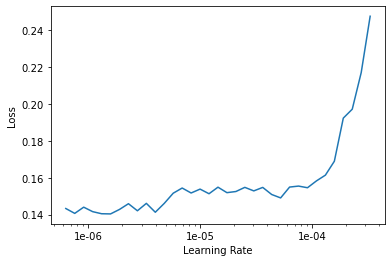

In [3]:
#Step:17
learn.unfreeze() # must be done before calling lr_find
learn.lr_find()
learn.recorder.plot()

In [4]:
#Stpe:18 - Retest with low learning rate
learn.fit_one_cycle(30, max_lr=slice(3e-5, 3e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.145838,2.900860,0.375000,00:35
1,0.141195,2.926162,0.370968,00:34
2,0.127481,2.938276,0.366935,00:34
3,0.130954,2.999785,0.383065,00:35
4,0.137974,2.995895,0.395161,00:34
5,0.162860,3.016863,0.375000,00:36
6,0.185087,3.220348,0.346774,00:34
7,0.244177,3.322111,0.383065,00:34
8,0.275600,3.443168,0.379032,00:34
9,0.275411,3.356496,0.366935,00:34


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


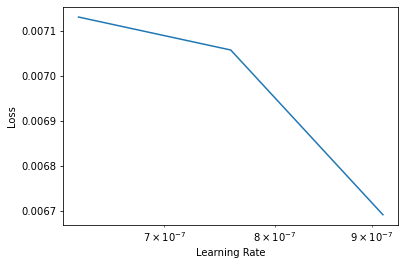

In [5]:
#Step:19
learn.unfreeze() # must be done before calling lr_find
learn.lr_find()
learn.recorder.plot()

In [6]:
#Step:20 - Cleansing images
from fastai.widgets import *

ds, idxs = DatasetFormatter().from_toplosses(learn)
ImageCleaner(ds, idxs, path)

Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())

In [7]:
#Step:21 - Check miscalssification
try:
    df = pd.read_csv('G:/DataScienceProject/osic-pulmonary-fibrosis-progression/train1/cleaned.csv', header='infer')
    df['class'] = df.name.str.rsplit("\\", expand=True)[0]
    if (df['class'].all() != df['label'].all()) == True:
        os.remove('G:/DataScienceProject/osic-pulmonary-fibrosis-progression/train1/cleaned.csv')
        os.remove('G:/DataScienceProject/osic-pulmonary-fibrosis-progression/train1/models/tmp.pth')
        os.rmdir('G:/DataScienceProject/osic-pulmonary-fibrosis-progression/train1/models')
        
except:
    print("!!!miscalssification!!!")

In [8]:
#Step:22 - Finalize model
path = 'G:/DataScienceProject/osic-pulmonary-fibrosis-progression/train1'
folderList = os.listdir(path)
data = ImageDataBunch.from_folder(path,
                                  train=".",
                                  test="../cv",
                                  valid_pct=0.2,
                                  classes=folderList)

epoch,train_loss,valid_loss,accuracy,time
0,0.719496,0.561790,0.891129,00:33
1,0.706546,0.556154,0.895161,00:33
2,0.643654,0.536871,0.879032,00:33
3,0.555178,0.511520,0.883065,00:33
4,0.450058,0.533928,0.879032,00:34
5,0.358610,0.506421,0.887097,00:33
6,0.287691,0.499318,0.899194,00:32
7,0.234890,0.539319,0.899194,00:32
8,0.202684,0.544670,0.883065,00:32
9,0.179984,0.564589,0.875000,00:32


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,accuracy,time
0,0.012963,0.599274,0.907258,00:34
1,0.017083,0.618222,0.907258,00:34
2,0.020044,0.630392,0.899194,00:34
3,0.023004,0.647684,0.907258,00:34
4,0.030135,0.598834,0.899194,00:34
5,0.043101,0.817760,0.830645,00:34
6,0.103317,1.072222,0.770161,00:35
7,0.156229,1.465858,0.717742,00:34
8,0.202921,1.175298,0.745968,00:34
9,0.220302,1.444247,0.709677,00:34


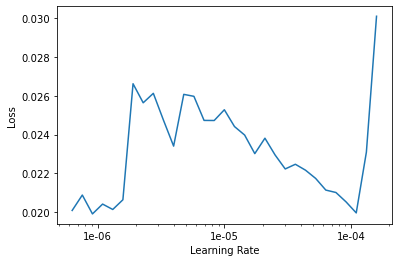

In [9]:
#Step:23 - Run final model
learn.data = data
learn.freeze()
learn.fit_one_cycle(30)
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()
learn.fit_one_cycle(30, max_lr=slice(3e-5, 3e-4))

In [10]:
learn.export('G:/DataScienceProject/osic-pulmonary-fibrosis-progression/fastai-remove-idx.pkl')

In [11]:
#Srep:24 - Load train and test DFs
import pandas as pd
import os
import cv2

trainDF  = pd.read_csv("G:/DataScienceProject/osic-pulmonary-fibrosis-progression/trainDF_Phase1.csv")
testDF  = pd.read_csv("G:/DataScienceProject/osic-pulmonary-fibrosis-progression/testDF_Phase1.csv")

#Add col for fastai predic train/test
trainDF['imgFVC'] = 0
testDF['imgFVC'] = 0
trainDF['imgFVC']  = trainDF['imgFVC'] .astype('int32')
testDF['imgFVC']  = testDF['imgFVC'] .astype('int32')


#Reorder colscolList = list(trainDF.columns)
colList = list(trainDF.columns)
colList.remove('FVC')
colList.append('FVC')

trainDF = trainDF[colList]
testDF = testDF[colList]

In [12]:
#Step:25 - Load the full model - Fastai
from fastai.vision import *
import warnings
warnings.filterwarnings('ignore')
import fastai
from fastai.metrics import error_rate

#learn=create_cnn(data, models.resnet34, metrics=error_rate)
#learn.load('G:/DataScienceProject/osic-pulmonary-fibrosis-progression' , 'fastai-test’)
learn = load_learner('G:/DataScienceProject/osic-pulmonary-fibrosis-progression/', 'fastai-remove-idx.pkl')

In [13]:
#Step:26 - Image prediction
path = 'G:/DataScienceProject/osic-pulmonary-fibrosis-progression/train2/'
for i in range(0, len(trainDF)):
    file = path + str(trainDF['Patient'].loc[i]) + '_' + str(trainDF['Weeks'].loc[i]) + '.jpg'
    try:
        img = open_image(file)
        pred_class, pred_idx, output = learn.predict(img)
        trainDF['imgFVC'].loc[i] = pred_class
    except:
        continue
path = 'G:/DataScienceProject/osic-pulmonary-fibrosis-progression/test2/'
for i in range(0, len(testDF)):
    file = path + str(testDF['Patient'].loc[i]) + '_' + str(testDF['Weeks'].loc[i]) + '.jpg'
    try:
        img = open_image(file)
        pred_class, pred_idx, output = learn.predict(img)
        testDF['imgFVC'].loc[i] = pred_class
    except:
        continue  
trainDF.to_csv("G:/DataScienceProject/osic-pulmonary-fibrosis-progression/trainDF_Phase2.csv", index=False)
testDF.to_csv("G:/DataScienceProject/osic-pulmonary-fibrosis-progression/testDF_Phase2.csv", index=False)

# Part3 - Combine Image Classification And ML

In [20]:
#Step:27 - Load Caret
import nbconvert
import pandas as pd
from pycaret.regression import *

trainDF = pd.read_csv('G:/DataScienceProject/osic-pulmonary-fibrosis-progression/trainDF_Phase2.csv')
testDF = pd.read_csv('G:/DataScienceProject/osic-pulmonary-fibrosis-progression/testDF_Phase2.csv')
exp1 = setup(trainDF, target = 'FVC')

 
Setup Succesfully Completed!


,Description,Value
0,session_id,1084
1,Transform Target,False
2,Transform Target Method,None
3,Original Data,"(1538, 9)"
4,Missing Values,False
5,Numeric Features,4
6,Categorical Features,4
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


In [21]:
#Step:28 - Compare modules
compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Regression,13.931700,258.693500,16.074700,0.999600,0.007200,0.005800
1,Elastic Net,13.996600,264.890900,16.263900,0.999600,0.007300,0.005900
2,Orthogonal Matching Pursuit,14.470800,286.139700,16.900000,0.999600,0.007500,0.006100
3,Bayesian Ridge,14.321600,275.215300,16.578700,0.999600,0.007300,0.005900
4,Ridge Regression,14.666300,296.348100,17.201400,0.999600,0.007500,0.006100
5,Gradient Boosting Regressor,15.586000,640.736700,23.114000,0.999100,0.008900,0.006400
6,Random Forest,16.082000,693.195700,23.739600,0.999000,0.010400,0.006700
7,Decision Tree,18.735300,801.761400,26.845000,0.998900,0.011000,0.007700
8,Extreme Gradient Boosting,15.927800,764.895400,24.950300,0.998900,0.008600,0.006300
9,Extra Trees Regressor,17.206800,785.945200,26.308400,0.998900,0.012000,0.007300


In [22]:
#Step:29 - Create model
lasso = create_model('lasso')
ridge = create_model('ridge')
elastic = create_model('en')

# stacking models
stacker = stack_models(estimator_list = [lasso, ridge,elastic])

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,8.118100e+00,1.085753e+02,1.041990e+01,9.998000e-01,0.0048,0.0035
1,3.299945e+08,5.880403e+18,2.424954e+09,-7.251169e+12,2.0310,56151.9314
2,8.399700e+00,1.393574e+02,1.180500e+01,9.998000e-01,0.0044,0.0031
3,7.228800e+00,8.582240e+01,9.264000e+00,9.999000e-01,0.0037,0.0029
4,1.071540e+08,4.133508e+17,6.429237e+08,-5.418939e+11,2.3535,37881.9742
5,7.018800e+00,8.892250e+01,9.429900e+00,9.999000e-01,0.0044,0.0030
6,1.426684e+08,2.177908e+18,1.475774e+09,-2.728416e+12,1.4426,28279.1765
7,7.628800e+00,9.974070e+01,9.987000e+00,9.998000e-01,0.0046,0.0032
8,7.513900e+00,9.456480e+01,9.724400e+00,9.999000e-01,0.0040,0.0030
9,6.331500e+00,6.183530e+01,7.863500e+00,9.999000e-01,0.0034,0.0026


In [23]:
#Step:30 - Tune model
save_experiment(experiment_name = 'G:/DataScienceProject/osic-pulmonary-fibrosis-progression/Exp1')

Experiment Succesfully Saved


In [24]:
#Step:31 - Prediction
prediction = predict_model(stacker, data = testDF)
prediction.to_csv("G:/DataScienceProject/osic-pulmonary-fibrosis-progression/prediction.csv", index=False)

In [26]:
prediction.to_csv("G:/DataScienceProject/osic-pulmonary-fibrosis-progression/prediction.csv", index=False)

In [10]:
#Step:32 - Load prediction
import pandas as pd

prediction = pd.read_csv("G:/DataScienceProject/osic-pulmonary-fibrosis-progression/prediction.csv")
prediction.head()

,Patient,Weeks,Percent,Age,Sex,SmokingStatus,FVCnrm,imgFVC,FVC,Label
0,ID00419637202311204720264,6,58.254,73,11,19,39,8,3020,2984.1629
1,ID00421637202311550012437,15,55.712,68,11,19,34,7,2739,2669.6413
2,ID00422637202311677017371,6,51.862,73,11,19,19,4,1930,1850.7698
3,ID00423637202312137826377,17,53.951,72,11,19,44,9,3294,3228.4937
4,ID00426637202313170790466,0,52.063,73,11,23,37,0,2925,2868.4108


In [11]:
#Step:33 - Create submission
prediction['Patient_Week'] = ''
for i in range(0, len(prediction)):
    prediction['Patient_Week'].loc[i] =  str(prediction['Patient'].loc[i]) + str('_') + str(prediction['Weeks'].loc[i])
prediction['Confidence'] = 100
prediction['Label'] = prediction['Label'].astype(int)
prediction['FVC'] = prediction['Label']
prediction = prediction.drop(['Patient', 'Weeks', 'Percent', 'Age', 'Sex', 'SmokingStatus', 'FVCnrm', 'imgFVC', 'Label'], axis=1)
colList = ['Patient_Week', 'FVC', 'Confidence']
prediction =  prediction[colList]
prediction.to_csv("G:/DataScienceProject/osic-pulmonary-fibrosis-progression/submmit1.csv", index=False)

C:\Program Files\Python38\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [12]:
prediction.head()

,Patient_Week,FVC,Confidence
0,ID00419637202311204720264_6,2984,100
1,ID00421637202311550012437_15,2669,100
2,ID00422637202311677017371_6,1850,100
3,ID00423637202312137826377_17,3228,100
4,ID00426637202313170790466_0,2868,100
